In [158]:
import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from functools import reduce
import seaborn as sns
from nltk.corpus import stopwords

In [159]:
df = pd.read_csv('apps.csv')
df = df.rename(columns={"id": "app_id"})
df = df[['app_id','title','description']]

In [160]:
# removes punctuation and converts all words to lower case
def clean_text(article):
    clean1 = re.sub(r'['+string.punctuation + '’—”'+']', "", article.lower())
    return re.sub(r'\W+', ' ', clean1)
df['tokenized'] = df['description'].map(lambda x: clean_text(x))

In [161]:
# remove stopword
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words= 'english')
# Stemming
st = PorterStemmer()
df['tokenized'] = df['tokenized'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [162]:
# generate TF-IDF matrix
tfidf_matrix = tf.fit_transform(df['tokenized'])

In [163]:
df.head()

,app_id,title,description,tokenized
0,1,Hit Counter,Show off your site traffic using Hit Counter f...,show off your site traffic use hit counter for...
1,2,Categories Uncomplicated,Simple categories for Shopify collections \n O...,simpl categori for shopifi collect one of the ...
2,3,Ads by Varinode,"For a limited time, all new installs will rece...",for a limit time all new instal will receiv 10...
3,4,All in One Metafields,Simple & Easy To Use \n Custom meta fields for...,simpl easi to use custom meta field for produc...
4,5,Product Options and Customizer,FREE Installation Service. Just follow these 3...,free instal servic just follow these 3 step ju...


In [164]:
# All APP Description Wordcloud
def show_wordcloud(df, col_name, title = 'All APPs'):
    col = str(col_name)
    data = df[col]
    filtered_words = set(['app','shopifi','store','product'])
    all_filtered_words = filtered_words.union(set(STOPWORDS))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=all_filtered_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

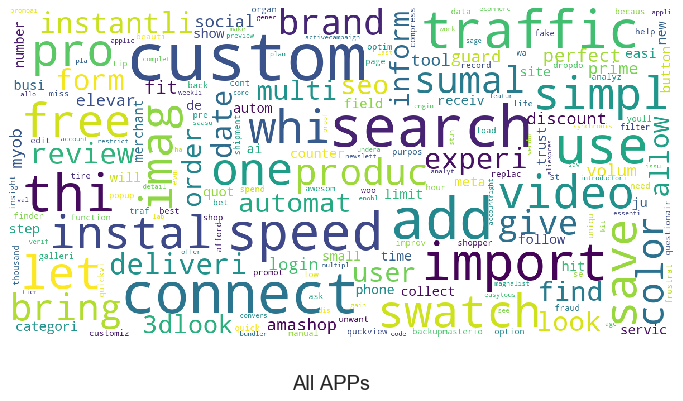

In [165]:
show_wordcloud(df, 'tokenized')

In [166]:
# Single APP Description Wordcloud
def app_wordcloud(df, col_name, app_id, title = None):
    col = str(col_name)
    data = df[df['app_id'] == app_id]['tokenized'][app_id-1]
    title = df[df["app_id"] == app_id]["title"][app_id-1]
    filtered_words = set(['app','shopifi','store','product'])
    all_filtered_words = filtered_words.union(set(STOPWORDS))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=all_filtered_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

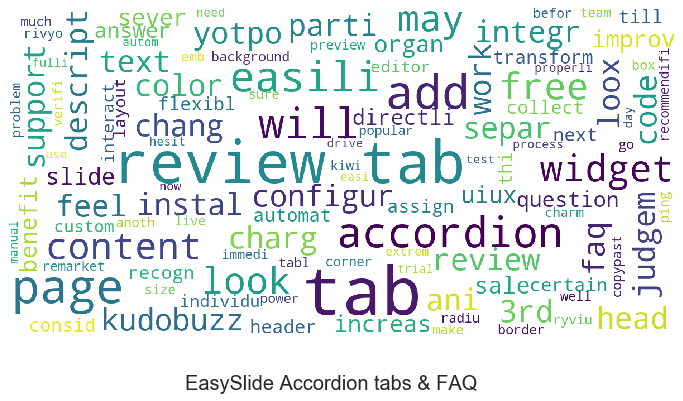

In [167]:
app_wordcloud(df, 'tokenized', 279)

In [168]:
# generating the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) 
# creating a Series for the app titles so they are associated to an ordered numerical list
indices = pd.Series(df.index)

In [169]:
#  defining the function that takes in app title as input and returns the top N recommended apps
def recommendations(app_id, top, cosine_sim = cosine_sim):
    
    # initializing the empty list of recommended movies
    recommended_apps = []
    
    # gettin the index of the app that matches the title
    idx = indices[indices == app_id-1].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_n_indexes = list(score_series.iloc[1:top+1].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_n_indexes:
        recommended_apps.append(list(df.index)[i])
    
    print("Recommending " + str(top) + " APPs similar to the APP " + str(app_id) + " - " + df[df["app_id"] == app_id]["title"][app_id-1] +":")
    # print(df[df["app_id"] == app_id]["description"][app_id-1])
    print("****************************************************************************************************************") 
    for i in recommended_apps:
        print("Similarity: " + str(score_series[i]))
        print("APP " + str(i+1) + " - " + df[df["app_id"] == (i+1)]["title"][i])
        print("****************************************************************************************************************") 

In [170]:
recommendations(279, 5, cosine_sim = cosine_sim)

Recommending 5 APPs similar to the APP 279 - EasySlide Accordion tabs & FAQ:
****************************************************************************************************************
Similarity: 0.8698969427969696
APP 358 - Easy Tabs ‑ Product Tabs
****************************************************************************************************************
Similarity: 0.8142793609167723
APP 2730 - FREE Tabs ‑ Product page tabs
****************************************************************************************************************
Similarity: 0.8075838478990744
APP 132 - Tabs by Station
****************************************************************************************************************
Similarity: 0.766494189330274
APP 2102 - My Tabs
****************************************************************************************************************
Similarity: 0.7654620439526417
APP 836 - FREE Tabs ‑ Easy Product Tabs
*******************************************

In [178]:
Ratings = pd.read_csv("reviews.csv",usecols=['author','app_id','rating'])
# drop missing values
ratings_dropna = Ratings.dropna()
# count average ratings for users rating the same app several times
avg_ratings = ratings_dropna.groupby(["author","app_id"],as_index=False)['rating'].mean()
# drop inactive users with number of rating < 10
counts = avg_ratings['author'].value_counts()
avg_ratings = avg_ratings[avg_ratings['author'].isin(counts[counts >= 10].index)]
# assign user id
final_ratings = avg_ratings.assign(user_id=(avg_ratings['author']).astype('category').cat.codes)
# reset index
final_ratings = final_ratings.reset_index(drop=True)
final_ratings

,author,app_id,rating,user_id
0,24k Gold Ch,1,5.0,0
1,24k Gold Ch,367,5.0,0
2,24k Gold Ch,407,5.0,0
3,24k Gold Ch,586,5.0,0
4,24k Gold Ch,595,5.0,0
5,24k Gold Ch,841,5.0,0
6,24k Gold Ch,942,5.0,0
7,24k Gold Ch,1014,5.0,0
8,24k Gold Ch,1372,5.0,0
9,24k Gold Ch,1389,5.0,0


In [179]:
app_count = pd.DataFrame(final_ratings.groupby('user_id')['app_id'].count())
app_count = user_count.rename(columns={"app_id": "app_counts"})
app_count

,user_counts
app_id,
1,3
2,5
3,64
4,4
5,4
6,6
7,1
8,8
11,6


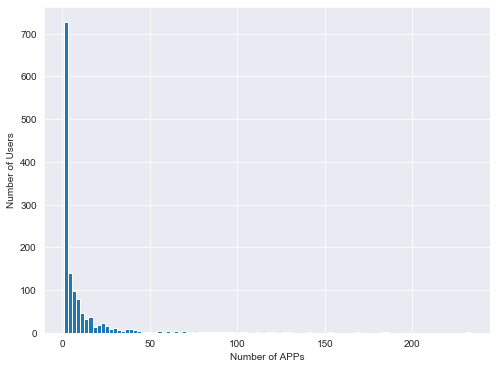

In [180]:
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.xlabel("Number of APPs")
plt.ylabel("Number of Users")
plt.rcParams['patch.force_edgecolor'] = True
app_count['user_counts'].hist(bins=100)

In [181]:
# normalize ratings to range from -0.5 to 0.5
final_ratings['normalized_rating'] = final_ratings.rating.transform(lambda x: (x - 1)/4-0.5)
final_ratings[final_ratings['rating'] == 5] 

,author,app_id,rating,user_id,normalized_rating
0,24k Gold Ch,1,5.0,0,0.5
1,24k Gold Ch,367,5.0,0,0.5
2,24k Gold Ch,407,5.0,0,0.5
3,24k Gold Ch,586,5.0,0,0.5
4,24k Gold Ch,595,5.0,0,0.5
5,24k Gold Ch,841,5.0,0,0.5
6,24k Gold Ch,942,5.0,0,0.5
7,24k Gold Ch,1014,5.0,0,0.5
8,24k Gold Ch,1372,5.0,0,0.5
9,24k Gold Ch,1389,5.0,0,0.5


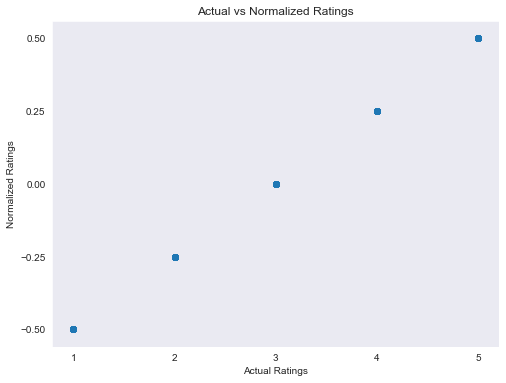

In [182]:
plt.figure(figsize=(8,6))
plt.scatter(final_ratings['rating'], final_ratings['normalized_rating'])
plt.xticks([1,2,3,4,5])
plt.yticks([-0.5,-0.25,0,0.25,0.5])
plt.xlabel("Actual Ratings")
plt.ylabel("Normalized Ratings")
plt.title("Actual vs Normalized Ratings")
plt.show()

In [176]:
def combined_recommendations(user_id, n):
    rated = final_ratings[final_ratings['user_id']==user_id]
    rated_app = rated[['app_id', 'normalized_rating']]
    rated_app = rated_app.rename(columns={"app_id": "my_app_id"})
    dfs = [find_multiplied_similarity(row) for idx, row in rated_app.iterrows()]
    merged_dfs = reduce(lambda x,y: pd.merge(x, y, on='app_id'), dfs)
    merged_dfs['sum'] = merged_dfs.drop('app_id', axis=1).sum(axis=1)
    final_scores =  merged_dfs[['app_id','sum']]
    final_scores['normalized_score'] = final_scores['sum'].transform(lambda x: (x - min(x))/(max(x)-min(x)))
    # drop rated apps
    my_app_id = rated_app['my_app_id'].tolist()
    final_scores = final_scores[~final_scores.app_id.isin(my_app_id)]
    # sort top n by calculated similarity
    top_n = final_scores.nlargest(n, 'normalized_score')
    app_info = df[['app_id','title']]
    top_n = top_n.merge(app_info, on = 'app_id', how='inner')
    del top_n['sum']
    top_n = top_n.reset_index(drop=True)
    idx = final_ratings[final_ratings['user_id'] == user_id]['author'].index[0]
    print("Top " + str(n) + " recommendations for user " + final_ratings[final_ratings['user_id'] == user_id]['author'][idx] + ":")
    return top_n
    
def find_multiplied_similarity(row):
    '''
    generate similarity dataframe
    '''
    my_app_id = row['my_app_id']
    rating = row['normalized_rating']
    sim_scores = pd.DataFrame(cosine_sim[indices[indices == my_app_id-1].index[0]], columns = ['score'])
    sim_scores['app_id'] = sim_scores.index + 1
    sim_scores = sim_scores.reset_index(drop=True)
    sim_scores['multiplied_score'] = sim_scores['score'] * rating
    del sim_scores['score']
    return sim_scores

In [177]:
combined_recommendations(717,10)

Top 10 recommendations for user Sachastyles:


,app_id,normalized_score,title
0,1735,0.944007,Sticky Cart & Cart Drawer
1,2649,0.929225,Product Options and Customizer
2,772,0.920893,Product Personalizer
3,2160,0.862332,Bold Product Options
4,406,0.860323,Full Page Zoom
5,1950,0.851746,Customer Photo Uploader
6,2782,0.849859,Product Options
7,643,0.840530,MobiApp ‑ Mobile app builder
8,608,0.837100,Better Sticky Button
9,2531,0.836367,Related Products Pro


In [142]:
final_ratings[final_ratings['author'] == 'Sachastyles']

,author,app_id,rating,user_id,normalized_rating
10365,Sachastyles,11,5.0,717,0.50
10366,Sachastyles,57,5.0,717,0.50
10367,Sachastyles,168,5.0,717,0.50
10368,Sachastyles,232,1.0,717,-0.50
10369,Sachastyles,295,5.0,717,0.50
10370,Sachastyles,371,1.0,717,-0.50
10371,Sachastyles,372,5.0,717,0.50
10372,Sachastyles,408,5.0,717,0.50
10373,Sachastyles,437,5.0,717,0.50
10374,Sachastyles,448,5.0,717,0.50


In [143]:
user_717 = pd.read_csv('user_717.csv')
user_717 = user_717.merge(df, on = 'app_id', how = 'inner')
user_717 = user_717[['author','app_id','recommender_score','title']]
user_717 = user_717.rename(columns={"app_id": "recommended_app"})
print("Top 10 recommendations for user Sachastyles:")
top_10 = user_717.nlargest(10, 'recommender_score')
top_10

Top 10 recommendations for user Sachastyles:


,author,recommended_app,recommender_score,title
0,Sachastyles,1735,0.938000,Sticky Cart & Cart Drawer
1,Sachastyles,772,0.864025,Product Personalizer
2,Sachastyles,2322,0.844379,IC Conversion Booster
3,Sachastyles,406,0.835725,Full Page Zoom
4,Sachastyles,2588,0.830394,Easy Announce Bar
5,Sachastyles,1585,0.826155,WishList + Reminder
6,Sachastyles,2649,0.822729,Product Options and Customizer
7,Sachastyles,321,0.822638,Wishlist @ $2
8,Sachastyles,33,0.822613,SEO Images All‑In‑One Seo
9,Sachastyles,376,0.818522,SEO ‑ All in One & Auto SEO


In [185]:
print("Recommended Apps for user - Vapel1fe:")
Vapel1fe = pd.read_csv('Vapel1fe.csv')
Vapel1fe

Recommended Apps for user - Vapel1fe:


,top,app_id,title
0,1,115,Stock Sync
1,2,1425,Similar Product Recommender
2,3,123,Twitter Timeline
3,4,1749,Carbon Checkout
4,5,680,Pickzen


In [187]:
print("Recommended Apps for user - Sachastyles:")
Sachastyles = pd.read_csv('Sachastyles.csv')
Sachastyles

Recommended Apps for user - Sachastyles:


,top,app_id,title
0,1,772,OC Check
1,2,1815,Zelina
2,3,406,Bold Product Options
3,4,2649,Magic Mirror: Optics & Fashion
4,5,110,Give & Grow
